#### Compare plain MC with MLMC for a European call option

Let $\varepsilon $ is the target root mean square (RMS) error.
| Symbol | What it counts | Why it matters |
|--------|----------------|----------------|
| $n_{\text{steps}} = 2^{\ell}$ | **Time-steps inside *one* Euler path** on level $\ell$ (step size $h_\ell = T / 2^{\ell}$). | Controls the **bias**: smaller $h_\ell$ → smaller discretisation error. |
| $N_\ell$ | **Number of coupled sample paths** simulated on level $\ell$ in MLMC. | Controls the **variance** contribution of that level.  MLMC chooses $$N_\ell\propto\frac{\sqrt{V_\ell/C_\ell}}{\varepsilon^{2}}$$ to minimise total cost (where $V_\ell$ and $C_\ell$ are respectively the variance and cost of level $\ell$).|
| $N_{\text{MC}}$ | **Total paths** in the single-level Monte-Carlo run, all generated on the finest grid (with $n_{\text{steps}} = 2^{L_{\text{fine}}}$). | Chosen from $$N_{\text{MC}}=\Bigl\lceil\frac{\operatorname{Var}[P_h]}{\varepsilon^{2}}\Bigr\rceil$$ so that the statistical error meets the tolerance (where $P_h$ is the estimated payoff using a numerical scheme with time step h).|

* In **plain MC** there is only one level, so every path uses the finest grid and $N_{\text{MC}}$ handles all the variance.  
* In **MLMC** the work is split: coarse levels are cheap so we take many paths ($N_\ell$ large); fine levels are expensive so we take fewer paths ($N_\ell$ small), yet the combined estimator still hits the target RMS error $\varepsilon$.


Let $\theta \in (0,1)$ is a tuning parameter that controls how the total error budget $\varepsilon$ is split between bias and variance.
| &nbsp; | **Single-level Monte-Carlo (plain MC)** | **Multilevel Monte-Carlo (our `MLMC` class)** |
|---|---|---|
| **Unknown quantity we must decide before the full run** | Total number of paths $N$ | Number of paths **per level** $N_\ell$ **and** how many levels $L$ |
| **Formula that fixes the paths** | $\displaystyle N \;=\;\Bigl\lceil \tfrac{\operatorname{Var}[P]}{\varepsilon^{2}}\Bigr\rceil$ | $\displaystyle N_\ell \;=\;\Bigl\lceil \frac{\sqrt{V_\ell/C_\ell}\,\sum_k\sqrt{V_k C_k}}{(1-\theta)\,\varepsilon^{2}}\Bigr\rceil$  + bias test |
| **What we need before we can apply that formula** | A reasonable estimate of $\operatorname{Var}[P]$ | Estimates of the **means** $m_\ell$, **variances** $V_\ell$, **costs** $C_\ell$ at every level |
| **How it gets those estimates** | Run a **pilot** batch (e.g. 10 000 paths) once, then freeze $N$ | Starts with `N0` pilot samples *at every level*, updates the empirical stats, **re-computes $N_\ell$**, adds another batch (`dNl`), repeats until tolerance is met → *self-piloting* |


In [1]:
import sys, os, time, math
import numpy as np
import matplotlib.pyplot as plt

# --- local package ------------------------------------------------------------
sys.path.append(os.path.abspath('..'))
from mlmc import MLMC
from mlmc.bs_model import MilsteinBSLevelFunction, bs_exact_call
from mlmc.payoffs import call_payoff

In [ ]:
#  parameters
S0, K, r, sigma, T = 100.0, 100.0, 0.05, 0.20, 1.0
exact             = bs_exact_call(S0, K, r, sigma, T)  
disc              = math.exp(-r * T)

In [ ]:
# mlmc setup
payoff   = lambda S: call_payoff(S, K)
level_fn = MilsteinBSLevelFunction(S0, r, sigma, T, payoff,verbose=False).simulate
mlmc_obj = MLMC(level_fn, Lmin=2, Lmax=20, N0=2000)

In [ ]:
#  Helper: streamed Euler MC on a *fixed* grid (n_steps = 2**L)
def euler_mc_price(n_steps: int, n_paths: int, *, block: int = 200_000):
    """Discounted call price using Euler, streaming in blocks to save RAM."""
    dt     = T / n_steps
    drift  = (r - 0.5 * sigma**2) * dt
    vol    = sigma * math.sqrt(dt)
    payoff_sum = 0.0
    done        = 0

    while done < n_paths:
        m   = min(block, n_paths - done)
        Z   = np.random.randn(m, n_steps)
        logS = math.log(S0) + (drift + vol * Z).cumsum(axis=1)
        ST   = np.exp(logS[:, -1])
        payoff_sum += payoff(ST).sum()
        done       += m

    return disc * payoff_sum / n_paths


In [ ]:
EPS = [0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]
PILOT_PATHS  = 20_000
rows         = []

for eps in EPS:
    # MLMC 
    t0 = time.perf_counter()
    price_ml, *_ = mlmc_obj.estimate(eps)
    rows.append(("MLMC", eps, price_ml, time.perf_counter() - t0))

    # single-level MC (Euler, *same bias* as MLMC)
    t0 = time.perf_counter()
    
    # 1) we choose spatial resolution so that bias ≲ ε / √2   (α≈1  ⇒  bias∝h)
    L_fine  = math.ceil(math.log2(1 / eps))          # h = T / 2**L
    n_steps = 2 ** L_fine

    # 2) pilot run to estimate variance of *this* discretised payoff
    pilot_price = euler_mc_price(n_steps, PILOT_PATHS, block=PILOT_PATHS)
    var_pay     = 2.0 * pilot_price**2 if pilot_price > 0 else S0**2  # safe upper bound
    N_mc        = math.ceil(var_pay / eps**2)

    # 3) main MC estimate on same grid
    
    price_mc = euler_mc_price(n_steps, N_mc)
    rows.append(("MC", eps, price_mc, time.perf_counter() - t0))

[Bias Check] L=2, extrapolated remainder=4.2354e+01, threshold=1.0000e-01
[Bias Check] L=3, extrapolated remainder=7.4130e-01, threshold=1.0000e-01
[Bias Check] L=4, extrapolated remainder=4.3733e-01, threshold=1.0000e-01
[Bias Check] L=5, extrapolated remainder=2.1854e-01, threshold=1.0000e-01
[Bias Check] L=6, extrapolated remainder=1.1435e-01, threshold=1.0000e-01
[Bias Check] L=7, extrapolated remainder=5.2018e-02, threshold=1.0000e-01
[Bias Check] L=2, extrapolated remainder=4.0598e+01, threshold=5.0000e-02
[Bias Check] L=3, extrapolated remainder=7.6233e-01, threshold=5.0000e-02
[Bias Check] L=4, extrapolated remainder=4.1972e-01, threshold=5.0000e-02
[Bias Check] L=5, extrapolated remainder=2.3001e-01, threshold=5.0000e-02
[Bias Check] L=6, extrapolated remainder=1.1915e-01, threshold=5.0000e-02
[Bias Check] L=7, extrapolated remainder=5.9766e-02, threshold=5.0000e-02
[Bias Check] L=8, extrapolated remainder=2.6446e-02, threshold=5.0000e-02
[Bias Check] L=2, extrapolated remaind

In [ ]:
print("\nComparison MC-Euler vs MLMC (exact price ≈ %.6f)\n" % exact)
print("\nComparison MC vs MLMC")
print(f"{'Method':<6} | {'eps':<8} | {'Estimate':<12} | {'Time (s)':<10}")
print("-"*46)
for method, eps, est, t in rows:
    print(f"{method:<6} | {eps:<8.5f} | {est:<12.6f} | {t:<10.4f}")


Comparison MC-Euler vs MLMC (exact price ≈ 10.450584)


Comparison MC vs MLMC
Method | eps      | Estimate     | Time (s)  
----------------------------------------------
MLMC   | 0.20000  | 10.660210    | 0.0093    
MC     | 0.20000  | 10.430440    | 0.0037    
MLMC   | 0.10000  | 10.436182    | 0.0143    
MC     | 0.10000  | 10.493065    | 0.0113    
MLMC   | 0.05000  | 10.419466    | 0.0278    
MC     | 0.05000  | 10.437706    | 0.0612    
MLMC   | 0.02500  | 10.431899    | 0.0626    
MC     | 0.02500  | 10.482367    | 0.4536    
MLMC   | 0.01250  | 10.462305    | 0.1710    
MC     | 0.01250  | 10.434054    | 3.6858    
MLMC   | 0.00625  | 10.444859    | 0.4253    
MC     | 0.00625  | 10.443753    | 28.8930   
MLMC   | 0.00313  | 10.453423    | 1.1548    
MC     | 0.00313  | 10.454744    | 231.9511  


In [ ]:
eps_list, err_mc, time_mc, err_ml, time_ml = [], [], [], [], []
for method, eps, est, t in rows:
    if method == "MC":
        eps_list.append(eps)
        err_mc.append(abs(est - exact))
        time_mc.append(t)
    else:
        err_ml.append(abs(est - exact))
        time_ml.append(t)

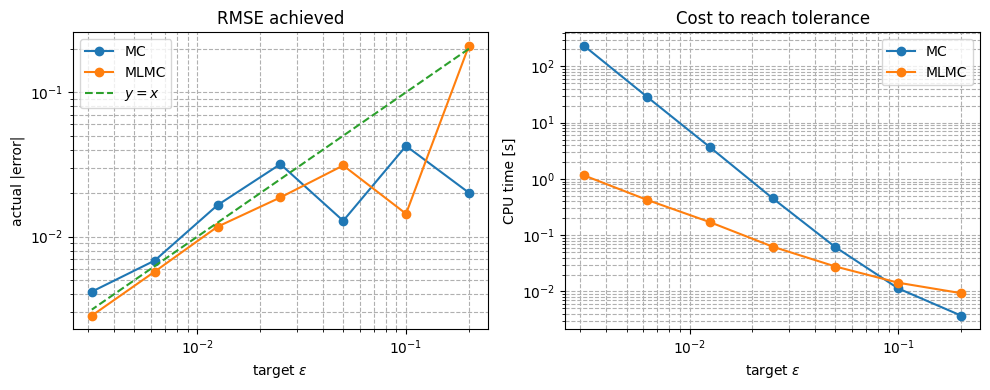

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(eps_list, err_mc,  "o-", label="MC")
plt.plot(eps_list, err_ml,  "o-", label="MLMC")
plt.plot(eps_list, eps_list, "--", label=r"$y=x$")  
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"target $\varepsilon$")
plt.ylabel("actual |error|")
plt.title("RMSE achieved")
plt.grid(True, which="both", ls="--")
plt.legend()

# Time plot
plt.subplot(1, 2, 2)
plt.plot(eps_list, time_mc, "o-", label="MC")
plt.plot(eps_list, time_ml, "o-", label="MLMC")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"target $\varepsilon$")
plt.ylabel("CPU time [s]")
plt.title("Cost to reach tolerance")
plt.grid(True, which="both", ls="--")
plt.legend()

plt.tight_layout()
plt.show()
